In [4]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    predestination,                          # Global Random seed for reproducibilty.
    iprint                                   # timestamped print with proc and ram info
)
from audace.audiodataset import AudioDataset # Main class for audio dataset handling


# Let's seed the various PRNGs, for reproducibility,
# using de default seed.
#
# Note1: this cannot apply to SQLite Random() function,
#       so its use is forbidden. e.g ORDER BY RANDOM()
#       should not be used in an sql query.
#
# Note2: repeated execution of a any cell requiring
#        randomness WILL NOT give the same result unless
#        predestination invocation was done from this cell
predestination()

EXP_NAME = "03 - SVM"


# Dataset name is the master key for dataset adressing
# Changing according to the dataset you want to process
DATASET_NAME = 'MAIN0500'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))

[2020-08-22/22:22:01.716|15.5%|63.1%|0.38GB] ------------------------------------------------------
[2020-08-22/22:22:01.716|00.0%|63.1%|0.38GB] DATASET NAME          : MAIN0500
[2020-08-22/22:22:01.716|00.0%|63.1%|0.38GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN0500
[2020-08-22/22:22:01.717|00.0%|63.1%|0.38GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN0500\MAIN0500.db
[2020-08-22/22:22:01.717|00.0%|63.1%|0.38GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN0500\samples
[2020-08-22/22:22:01.717|00.0%|63.1%|0.38GB] NB SOURCE AUDIO FILES : 48
[2020-08-22/22:22:01.717|00.0%|63.1%|0.38GB] SAMPLE RATE           : 22050
[2020-08-22/22:22:01.717|00.0%|63.1%|0.38GB] DURATION              : 0.5
[2020-08-22/22:22:01.717|00.0%|63.1%|0.38GB] OVERLAP               : 0.0
[2020-08-22/22:22:01.718|00.0%|63.1%|0.38GB] NB AUDIO CHUNKS       : 49579
[2020-08-22/22:22:01.719|00.0%|63.1%|0.38GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,28
1,CF003,1.0,7394
2,CJ001,0.0,1743
3,GH001,1.0,2886
4,Hive1,0.0,3111
5,Hive1,1.0,5458
6,Hive3,0.0,13273
7,Hive3,1.0,1339


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from functools import reduce
import numpy as np

FEATURE_NAME = 'mfcc8'
TEST_FRAC = 0.99
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'

def feature_serie_to_np(s):
    x = np.stack(s)
    shape = x.shape
    return x.reshape(shape[0], reduce((lambda x, y: x * y), shape[1:]) )


# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiments
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql)

# shuffle (and potentially truncate)
# Not needed, but may help during testing
df_shuffled = df.sample(frac=1)

# flatten features array
X = feature_serie_to_np(df_shuffled[FEATURE_NAME])

# get labels
y = df_shuffled['queen']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

# It is usually a good idea to scale the data for SVM training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create a svm Classifier
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

iprint('>>>>> Train')
#Train the model using the training sets
clf.fit(X_train, y_train)

iprint('>>>>> Predict')
#Predict the response for test dataset
y_pred = clf.predict(X_test)


iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-08-22/22:24:03.929|11.4%|63.7%|0.41GB] >>>>> Train
[2020-08-22/22:24:03.943|12.5%|63.7%|0.41GB] >>>>> Predict
[2020-08-22/22:24:04.997|14.9%|63.7%|0.41GB] Trained over 352 / Tested over 34880
[2020-08-22/22:24:05.002|28.6%|63.7%|0.41GB] Accuracy  : 0.9328841743119266
[2020-08-22/22:24:05.015|00.0%|63.7%|0.41GB] Precision : 0.9768354927365528
[2020-08-22/22:24:05.030|12.5%|63.7%|0.41GB] Recall    : 0.8825302985515814
[2020-08-22/22:24:05.044|12.5%|63.7%|0.41GB] F-Measure : 0.9272913625493058


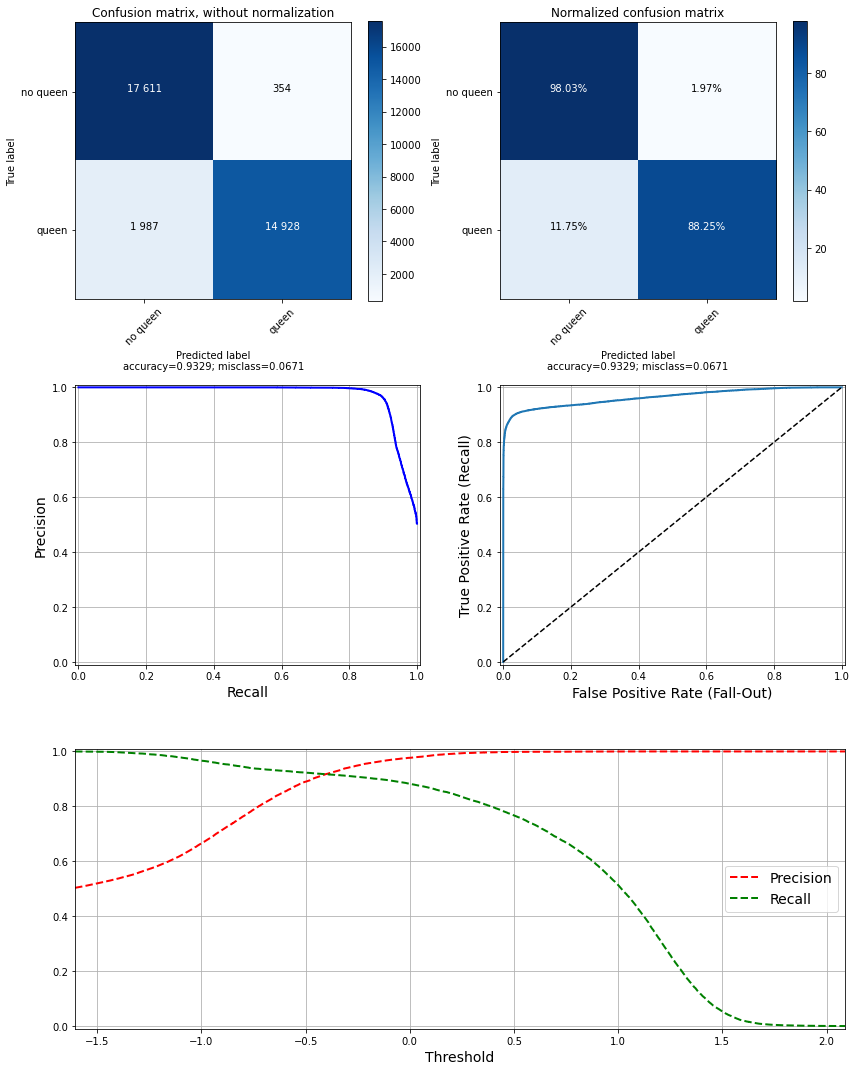

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    no queen       0.90      0.98      0.94     17965
       queen       0.98      0.88      0.93     16915

    accuracy                           0.93     34880
   macro avg       0.94      0.93      0.93     34880
weighted avg       0.94      0.93      0.93     34880

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.9639998917328576
------------------------------------------------------------------------------------------


In [8]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['no queen', 'queen']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = EXP_NAME + F"{KERNEL} - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}] - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

clf_full_report(clf, X_test, y_test, target_names, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

-------------------------------------
Accuracy: 0.34348480700793865
Precision: 0.00012112403100775194
Recall: 0.0007468259895444362
F1: 0.00020844189682126107


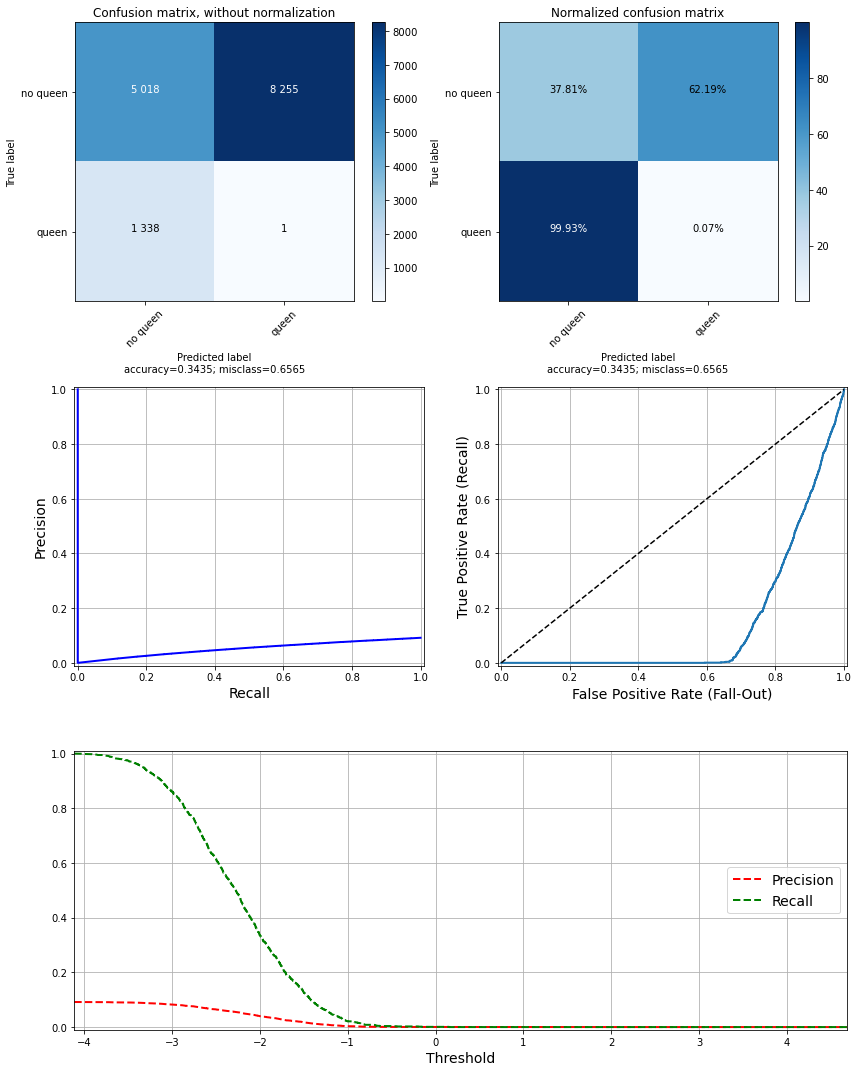

-------------------------------------
Accuracy: 0.3182401680476135
Precision: 0.0514018691588785
Recall: 0.004030780505679736
F1: 0.0074753652735304104


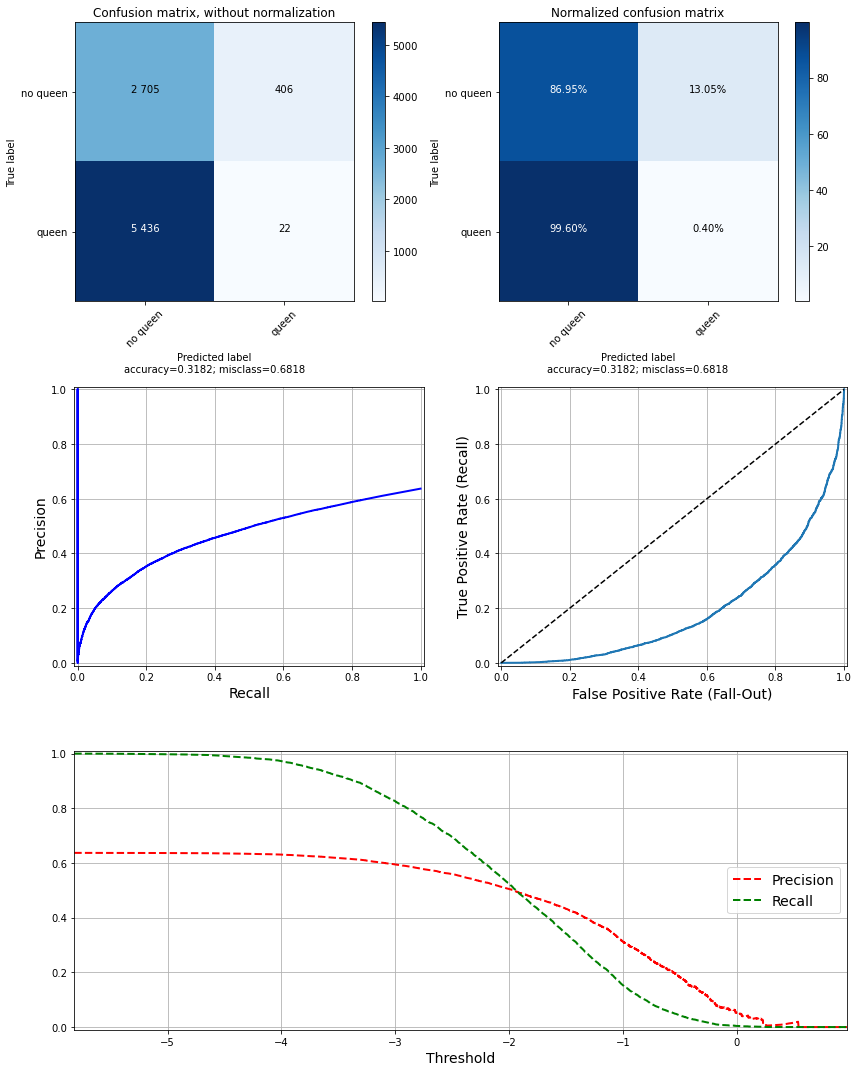

In [9]:
from sklearn import svm
from sklearn import metrics
from audace.plotters import clf_full_report
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

FEATURE_NAME = 'mfcc8'
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'
target_names = ['no queen', 'queen']

df_fold1 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive1'").sample(frac=1)
df_fold2 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive3'").sample(frac=1)




def process_svm(X_train_serie, y_train, X_test_serie, y_test):
    X_train = feature_serie_to_np(X_train_serie)
    X_test = feature_serie_to_np(X_test_serie)

    #Create a svm Classifier
    clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("-------------------------------------")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    
    return clf, X_test, y_test


c, X, y = process_svm(df_fold1[FEATURE_NAME], df_fold1['queen'], df_fold2[FEATURE_NAME], df_fold2['queen'])
clf_full_report(c, X, y, target_names)

c, X, y = process_svm(df_fold2[FEATURE_NAME], df_fold2['queen'], df_fold1[FEATURE_NAME], df_fold1['queen'])
clf_full_report(c, X, y, target_names)

